In [1]:
from analysis import load_chat, load_highlights, remove_missing_matches, cut_same_length
import re
import numpy as np
import pandas as pd

from sklearn.metrics import precision_recall_fscore_support, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

## Data Loading

In [2]:
def chat_hl_to_documents(ch_match, hl_match, frames_per_doc=210, hl_threshold=0.5, offset=0):
    # make non-overlapping windows of frames_per_doc/30 seconds
    # TODO: implement offset to adjust for comment lag
    chm = [ch_match[i:i+frames_per_doc] for i in range(0,len(ch_match),frames_per_doc)]
    hlm = [hl_match[i:i+frames_per_doc] for i in range(0,len(hl_match),frames_per_doc)]
    
    chm_docs = list()
    hlm_docs = list()
    
    for m_doc, h_doc in zip(chm, hlm):
        chm_docs.append(re.sub("\n+", " ", "".join(m_doc)).strip())
        
        # chm_docs.append("".join(m_doc))
        hlm_docs.append(int(sum(h_doc) >= hl_threshold))
    
    return chm_docs, hlm_docs

In [3]:
def shuffle_two_iters(a1, a2, rng_seed=42):
    # shuffles two iterables in the same way and turns them into numpy arrays
    shuffle_inds = list(range(len(a1)))
    np.random.default_rng(rng_seed).shuffle(shuffle_inds)
    
    ret1 = np.asarray(a1)[shuffle_inds]
    ret2 = np.asarray(a2)[shuffle_inds]
    return ret1, ret2

In [4]:
def load_train_val_docs(mode="train", load_random=5, random_state=42, shuffle=True, frames_per_doc=120, hl_threshold=0.5, offset=0):    
    if mode == "train":
        file_regex = "nalcs_w[134579]*_g[13]" # weeks 1,3,4,5,7,9 games 1 and 3 of each match for training
    if mode == "val":
        file_regex = "nalcs_w[268]*_g[13]" # weeks 2,6,8 games 1 and 3 of each match for validation

    chat = load_chat("data/final_data", load_random=load_random, random_state=random_state, file_identifier=file_regex)
    highlights = load_highlights("data/gt", file_identifier=file_regex)

    remove_missing_matches(chat, highlights)

    chat_docs = list()
    hl_docs = list()

    for match in chat.keys():
        ch_match, hl_match = cut_same_length(chat[match], highlights[match])
        cd, hd  = chat_hl_to_documents(ch_match, hl_match, frames_per_doc=frames_per_doc, hl_threshold=hl_threshold, offset=offset)
        # put all documents together
        chat_docs.extend(cd)
        hl_docs.extend(hd)

    # garbage collect chat and highlights    
    
    if shuffle:
        chat_docs, hl_docs = shuffle_two_iters(chat_docs, hl_docs)
        
    return chat_docs, hl_docs

In [11]:
ch_train, hl_train = load_train_val_docs(mode="train")

missing in highlights:	 {'nalcs_w5d2_C9_TMS_g1'}
missing in chat:	 {'nalcs_w4d3_FLY_C9_g3', 'nalcs_w1d3_TSM_IMT_g3', 'nalcs_w5d3_P1_C9_g1', 'nalcs_w9d2_FOX_NV_g3', 'nalcs_w7d2_CLG_DIG_g1', 'nalcs_w1d3_TSM_IMT_g1', 'nalcs_w1d3_DIG_C9_g1', 'nalcs_w4d1_IMT_DIG_g1', 'nalcs_w5d3_FLY_TSM_g3', 'nalcs_w3d3_P1_TSM_g3', 'nalcs_w1d3_DIG_C9_g3', 'nalcs_w3d2_TL_FOX_g1', 'nalcs_w1d1_FOX_P1_g1', 'nalcs_w1d2_FOX_IMT_g1', 'nalcs_w1d1_TSM_C9_g1', 'nalcs_w1d2_DIG_P1_g3', 'nalcs_w7d3_TL_NV_g1', 'nalcs_w9d2_TL_TSM_g3', 'nalcs_w7d3_IMT_TSM_g1', 'nalcs_w9d2_IMT_CLG_g1', 'nalcs_w4d2_TSM_NV_g1', 'nalcs_w9d1_C9_DIG_g1', 'nalcs_w9d3_TSM_P1_g1', 'nalcs_w9d3_CLG_NV_g1', 'nalcs_w1d2_CLG_TL_g1', 'nalcs_w7d2_NV_TSM_g3', 'nalcs_w9d2_TL_TSM_g1', 'nalcs_w9d3_FLY_TL_g3', 'nalcs_w3d1_NV_TL_g1', 'nalcs_w3d3_C9_FOX_g1', 'nalcs_w7d2_P1_FOX_g1', 'nalcs_w3d2_TL_FOX_g3', 'nalcs_w3d3_DIG_CLG_g1', 'nalcs_w1d3_TL_FLY_g3', 'nalcs_w9d2_FOX_NV_g1', 'nalcs_w4d1_C9_TL_g1', 'nalcs_w4d2_CLG_FOX_g1', 'nalcs_w4d3_FOX_TSM_g1', 'nalcs_w5d2_T

### Oversampling for balancing data

In [5]:
def balance_data_parallel(x, y, strategy="oversample"):
    x_pos = x[y == 1]
    y_pos = y[y == 1]
    x_neg = x[y == 0]
    y_neg = y[y == 0]
    if len(y_pos) != len(y_neg):
        x_small = x_pos if len(x_pos) < len(x_neg) else x_neg
        y_small = y_pos if len(y_pos) < len(y_neg) else y_neg
        x_large = x_pos if len(x_pos) >= len(x_neg) else x_neg
        y_large = y_pos if len(y_pos) >= len(y_neg) else y_neg
        
        if strategy == "oversample":            
            repeat_amount = int(len(y_large) / len(y_small))
            x_small_rep = np.repeat(x_small, repeat_amount)
            y_small_rep = np.repeat(y_small, repeat_amount)
            
            x_balanced = np.concatenate([x_small_rep, x_large])
            y_balanced = np.concatenate([y_small_rep, y_large])
        if strategy == "undersample":
            inds_under = np.random.choice(np.arange(len(x_large)), len(x_small), replace=False)
            
            x_large_under = x_large[inds_under]
            y_large_under = y_large[inds_under]
            
            x_balanced = np.concatenate([x_small, x_large_under])
            y_balanced = np.concatenate([y_small, y_large_under])
        
        return shuffle_two_iters(x_balanced, y_balanced)
    else:
        return x, y


In [13]:
# over-sample
ch_pos = ch_train[hl_train == 1]
hl_pos = hl_train[hl_train == 1]
ch_neg = ch_train[hl_train == 0]
hl_neg = hl_train[hl_train == 0]

df_sample_numbers = pd.DataFrame({"step": "before_over_sampling", "total_train_samples": [len(hl_train)], "num_highlight_samples": [len(hl_pos)],  "num_non_highlight_samples": [len(hl_neg)]})
df_sample_numbers

,step,total_train_samples,num_highlight_samples,num_non_highlight_samples
0,before_over_sampling,2768,355,2413


In [14]:
hl_pos_rep = np.repeat(hl_pos, int(len(hl_neg) / len(hl_pos)))
ch_pos_rep = np.repeat(ch_pos, int(len(hl_neg) / len(hl_pos)))

hl_train_balanced = np.concatenate([hl_pos_rep, hl_neg])
ch_train_balanced = np.concatenate([ch_pos_rep, ch_neg])

ch_train_balanced_shuffled, hl_train_balanced_shuffled = shuffle_two_iters(ch_train_balanced, hl_train_balanced)

df_sample_numbers = df_sample_numbers.append({"step": "after_over_sampling", "total_train_samples": len(hl_train_balanced_shuffled), "num_highlight_samples": len(hl_pos_rep),  "num_non_highlight_samples": len(hl_neg)}, ignore_index=True)
df_sample_numbers

,step,total_train_samples,num_highlight_samples,num_non_highlight_samples
0,before_over_sampling,2768,355,2413
1,after_over_sampling,4543,2130,2413


In [15]:
ch_train[hl_train == 1][:10]

array(['FeelsBad YOUR TIME TO SHINE FeelsBadMan WHAT HAPPENED TO FLYQUEST fly feelsbad FREEQUEST LUL CLOWN FIESTA KreyGasm easy lmao DIG PogChamp NA SO BAD 4Head j4 mid no more Jebaited DIGNITAS DIGNITAS PogChamp DIG PogChamp PogChamp PogChamp PogChamp gg POG lose vs dig = disband LUL DIG PogChamp WutFace FAILED QUEST LUL fly trolling DIG PogChamp NV LUL PLOWED haHAA m DIG PogChamp (poolparty) WutFace nv 9>2 Kappa DIG PogChamp',
       'QUEM É BRASIL, DIGITE 1 NICOLE ANISTON Kreygasm LUL LUL WTF WTF LOLOL balls? SSUMDAY PogChamp sumday 1 v9 FLYQUEST LL ??????? ????? HELLO??!? WutFace ???? ???? DIG PogChamp altec? kleane Kreygasm PogChamp team? KARTHUS YOOOO DOG keaneW keaneW keaneW keaneW keaneW LUL triple TAUNT Keane PogChamp ????? Throw LUL DIG PogChamp FLY????????? KEANE PogChamp ??????? BALLS LUL FIESTA BALLS ? KEANE PogChamp DIG IN 2017 PogChamp PogChamp LUL DIG PogChamp DIG PogChamp DIG PogChamp report balls LUL D2 flyquest wtf PogChamp PogChamp PogChamp PogChamp PogChamp PogCham

## Testing text classification with TFIDF and NaiveBayes
https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

### In individual steps


In [183]:
count_vect = CountVectorizer() # TODO add parameters
X_train_counts = count_vect.fit_transform(ch_train)
#X_train_counts = count_vect.fit_transform(ch_train_balanced_shuffled)

X_train_counts.shape

(2768, 6608)

In [184]:
count_vect.vocabulary_.get(u'pogchamp')

4541

In [185]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2768, 6608)

In [186]:
# y_train = hl_train
y_train = hl_train_balanced_shuffled

In [187]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [188]:
# load validation data
ch_val, hl_val = load_train_val_docs(mode="val")

missing in highlights:	 {'nalcs_w6d2_FOX_C9_g1'}
missing in chat:	 {'nalcs_w2d3_FOX_FLY_g3', 'nalcs_w8d2_TSM_FLY_g1', 'nalcs_w2d2_IMT_C9_g1', 'nalcs_w8d2_NV_DIG_g1', 'nalcs_w8d2_C9_IMT_g3', 'nalcs_w2d2_TSM_TL_g3', 'nalcs_w6d1_IMT_TL_g1', 'nalcs_w8d2_NV_DIG_g3', 'nalcs_w2d2_DIG_FOX_g3', 'nalcs_w8d2_TL_P1_g1', 'nalcs_w6d1_P1_CLG_g3', 'nalcs_w2d3_C9_CLG_g3', 'nalcs_w2d1_TSM_DIG_g1', 'nalcs_w6d1_P1_CLG_g1', 'nalcs_w2d3_C9_CLG_g1', 'nalcs_w8d2_C9_IMT_g1', 'nalcs_w2d3_NV_IMT_g3', 'nalcs_w8d2_TSM_FLY_g3', 'nalcs_w6d2_FLY_NV_g3', 'nalcs_w2d2_P1_NV_g1', 'nalcs_w2d2_DIG_FOX_g1', 'nalcs_w2d1_FLY_CLG_g1', 'nalcs_w2d1_TSM_DIG_g3', 'nalcs_w6d3_C9_FLY_g1', 'nalcs_w8d1_DIG_TL_g1', 'nalcs_w8d1_FOX_CLG_g1', 'nalcs_w6d2_TSM_CLG_g1', 'nalcs_w2d2_TSM_TL_g1', 'nalcs_w6d3_FOX_TL_g3', 'nalcs_w8d3_CLG_FLY_g1', 'nalcs_w8d3_P1_IMT_g1', 'nalcs_w2d3_P1_TL_g1', 'nalcs_w8d3_NV_C9_g1', 'nalcs_w6d2_P1_DIG_g3', 'nalcs_w6d1_IMT_TL_g3', 'nalcs_w8d3_TSM_FOX_g1', 'nalcs_w6d3_DIG_TSM_g1', 'nalcs_w2d3_FOX_FLY_g1', 'nalcs_w6d

In [189]:
y_true = hl_val

In [196]:
docs_new = ch_val
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

y_pred = clf.predict(X_new_tfidf)

"""
for doc, pred, true in zip(docs_new, y_pred, y_true):
        if pred == true == 1:
             print(doc, pred, true)
"""
print(precision_recall_fscore_support(y_true, y_pred, average="binary"))
print(accuracy_score(y_true, y_pred))

/home/max/miniconda3/envs/chat-highlight-detection/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TypeError: 'numpy.float64' object is not iterable

### In a pipeline

In [6]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

In [7]:
ch_train, hl_train = load_train_val_docs(mode="train", load_random=5, random_state=42)

missing in highlights:	 {'nalcs_w5d2_C9_TMS_g1'}
missing in chat:	 {'nalcs_w9d3_FLY_TL_g3', 'nalcs_w5d3_IMT_FOX_g1', 'nalcs_w7d2_P1_FOX_g1', 'nalcs_w3d2_C9_NV_g1', 'nalcs_w5d2_CLG_IMT_g1', 'nalcs_w9d1_FLY_FOX_g1', 'nalcs_w3d1_NV_TL_g1', 'nalcs_w7d3_TL_NV_g1', 'nalcs_w9d2_TL_TSM_g1', 'nalcs_w1d2_CLG_TL_g1', 'nalcs_w5d2_C9_TSM_g1', 'nalcs_w1d3_DIG_C9_g1', 'nalcs_w1d3_TL_FLY_g3', 'nalcs_w7d3_CLG_C9_g3', 'nalcs_w1d1_TSM_C9_g1', 'nalcs_w1d2_DIG_P1_g3', 'nalcs_w7d1_FLY_P1_g1', 'nalcs_w5d2_NV_FOX_g1', 'nalcs_w7d2_CLG_DIG_g1', 'nalcs_w5d2_C9_TSM_g3', 'nalcs_w5d3_FLY_TSM_g1', 'nalcs_w7d3_TL_NV_g3', 'nalcs_w7d1_TL_C9_g1', 'nalcs_w5d3_TL_CLG_g3', 'nalcs_w5d3_FLY_TSM_g3', 'nalcs_w3d2_CLG_TSM_g1', 'nalcs_w4d3_DIG_NV_g1', 'nalcs_w4d1_IMT_DIG_g1', 'nalcs_w9d2_FOX_NV_g1', 'nalcs_w4d3_CLG_P1_g1', 'nalcs_w1d2_FOX_IMT_g3', 'nalcs_w7d3_IMT_TSM_g1', 'nalcs_w3d2_TL_FOX_g1', 'nalcs_w9d3_TSM_P1_g1', 'nalcs_w7d3_FOX_DIG_g1', 'nalcs_w9d2_FOX_NV_g3', 'nalcs_w1d3_TSM_IMT_g3', 'nalcs_w1d3_TSM_IMT_g1', 'nalcs_w1d3_

In [8]:
# load validation data
ch_val, hl_val = load_train_val_docs(mode="val", load_random=5, random_state=42)

missing in highlights:	 {'nalcs_w6d2_FOX_C9_g1'}
missing in chat:	 {'nalcs_w6d2_FLY_NV_g3', 'nalcs_w2d2_DIG_FOX_g1', 'nalcs_w6d2_P1_DIG_g3', 'nalcs_w8d2_NV_DIG_g1', 'nalcs_w8d2_TSM_FLY_g1', 'nalcs_w2d1_FLY_CLG_g1', 'nalcs_w6d3_C9_FLY_g1', 'nalcs_w2d2_TSM_TL_g1', 'nalcs_w6d1_P1_CLG_g1', 'nalcs_w6d1_P1_CLG_g3', 'nalcs_w8d2_C9_IMT_g3', 'nalcs_w2d2_TSM_TL_g3', 'nalcs_w8d1_FOX_CLG_g1', 'nalcs_w8d3_NV_C9_g1', 'nalcs_w2d3_NV_IMT_g3', 'nalcs_w8d3_CLG_FLY_g1', 'nalcs_w6d1_IMT_TL_g1', 'nalcs_w2d1_TSM_DIG_g1', 'nalcs_w2d3_P1_TL_g1', 'nalcs_w6d3_FOX_TL_g1', 'nalcs_w8d3_P1_IMT_g1', 'nalcs_w2d3_FOX_FLY_g3', 'nalcs_w2d3_C9_CLG_g3', 'nalcs_w2d1_TSM_DIG_g3', 'nalcs_w8d1_DIG_TL_g1', 'nalcs_w6d3_FOX_TL_g3', 'nalcs_w2d2_P1_NV_g1', 'nalcs_w2d2_IMT_C9_g1', 'nalcs_w2d3_C9_CLG_g1', 'nalcs_w8d2_TL_P1_g1', 'nalcs_w6d3_DIG_TSM_g1', 'nalcs_w2d2_DIG_FOX_g3', 'nalcs_w6d2_TSM_CLG_g1', 'nalcs_w8d2_NV_DIG_g3', 'nalcs_w8d2_TSM_FLY_g3', 'nalcs_w8d3_TSM_FOX_g1', 'nalcs_w2d3_FOX_FLY_g1', 'nalcs_w8d2_C9_IMT_g1', 'nalcs_w6d

In [9]:
# x_val, y_val = balance_data_parallel(ch_val, hl_val, strategy="undersample") => doesn't make sense
x_val, y_val = ch_val, hl_val

In [34]:
x_train, y_train = balance_data_parallel(ch_train, hl_train, strategy="oversample")

In [11]:
text_clf.fit(x_train, y_train)
y_pred = text_clf.predict(x_val)

p,r,f,_ = precision_recall_fscore_support(y_val, y_pred, average="binary")
print(f"{p:.04f}, {r:.04f}, {f:.04f}, {accuracy_score(y_val, y_pred):.04f}")

0.2006, 0.3657, 0.2591, 0.7488


In [12]:
sum(hl_val==1), sum(hl_val==0)

(361, 2645)

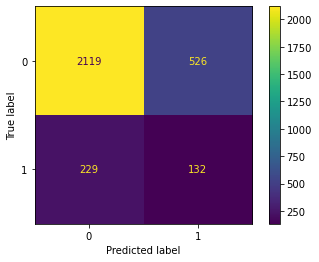

In [13]:
cf = ConfusionMatrixDisplay.from_estimator(text_clf, x_val, y_val)
plt.show()

In [14]:
print(classification_report(y_val, y_pred, target_names=["non-highlight", "highlight"]))

               precision    recall  f1-score   support

non-highlight       0.90      0.80      0.85      2645
    highlight       0.20      0.37      0.26       361

     accuracy                           0.75      3006
    macro avg       0.55      0.58      0.55      3006
 weighted avg       0.82      0.75      0.78      3006



In [15]:
def eval_results(y_true, y_pred):
    cf = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.show()
    print(classification_report(y_true, y_pred, target_names=["non-highlight", "highlight"]))

In [28]:
parameters = {
     'vect__ngram_range': [(1, 1), (1, 2)],
     'tfidf__use_idf': (True, False),
     'clf__alpha': (1e-2, 1e-3, 0.2, 0.5, 1.0),
}

In [29]:
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1, scoring="precision")

In [30]:
gs_clf = gs_clf.fit(x_train, y_train)

In [31]:
gs_clf.best_score_

0.6979607259125332

In [32]:
gs_clf.best_params_

{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}

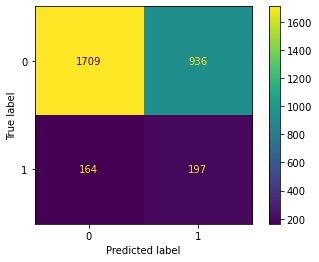

               precision    recall  f1-score   support

non-highlight       0.91      0.65      0.76      2645
    highlight       0.17      0.55      0.26       361

     accuracy                           0.63      3006
    macro avg       0.54      0.60      0.51      3006
 weighted avg       0.82      0.63      0.70      3006



In [33]:
best_test_clf = gs_clf.best_estimator_
y_pred = best_test_clf.predict(x_val)
eval_results(y_val, y_pred)

## Adding different embedding